<a href="https://colab.research.google.com/github/sergisalgueiro/Deep-learning-for-self-driving/blob/master/Behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get data from repository

In [104]:
# !git clone https://github.com/sergisalgueiro/Track1
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 29.98 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [105]:
!ls Track1/

driving_log.csv  IMG  README.md


In [106]:
# Data aug.
!pip3 install imgaug

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam
import random
import ntpath

# Data augm.
from imgaug import augmenters as iaa

In [108]:
datadir = 'Track1'
logname = 'driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, logname), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\salgueir\Desktop\driving_data\IMG\center_2019_02_07_17_35_33_142.jpg   
1  C:\Users\salgueir\Desktop\driving_data\IMG\center_2019_02_07_17_35_33_245.jpg   
2  C:\Users\salgueir\Desktop\driving_data\IMG\center_2019_02_07_17_35_33_348.jpg   
3  C:\Users\salgueir\Desktop\driving_data\IMG\center_2019_02_07_17_35_33_452.jpg   
4  C:\Users\salgueir\Desktop\driving_data\IMG\center_2019_02_07_17_35_33_554.jpg   

                                                                           left  \
0   C:\Users\salgueir\Desktop\driving_data\IMG\left_2019_02_07_17_35_33_142.jpg   
1   C:\Users\salgueir\Desktop\driving_data\IMG\left_2019_02_07_17_35_33_245.jpg   
2   C:\Users\salgueir\Desktop\driving_data\IMG\left_2019_02_07_17_35_33_348.jpg   
3   C:\Users\salgueir\Desktop\driving_data\IMG\left_2019_02_07_17_35_33_452.jpg   
4   C:\Users\salgueir\Desktop\driving_data\IMG\left_2019_02_07_17_35_33_554.jpg   

                                                                           right  \
0   C:\Users\salgueir\Desktop\driving_data\IMG\right_2019_02_07_17_35_33_142.jpg   
1   C:\Users\salgueir\Desktop\driving_data\IMG\right_2019_02_07_17_35_33_245.jpg   
2   C:\Users\salgueir\Desktop\driving_data\IMG\right_2019_02_07_17_35_33_348.jpg   
3   C:\Users\salgueir\Desktop\driving_data\IMG\right_2019_02_07_17_35_33_452.jpg   
4   C:\Users\salgueir\Desktop\driving_data\IMG\right_2019_02_07_17_35_33_554.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000078  
1  0.0       0.0       0.0      0.000078  
2  0.0       0.0       0.0      0.000079  
3  0.0       0.0       0.0      0.000078  
4  0.0       0.0       0.0      0.000078

In [109]:
# clean file names
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data.head()


center                              left  \
0  center_2019_02_07_17_35_33_142.jpg  left_2019_02_07_17_35_33_142.jpg   
1  center_2019_02_07_17_35_33_245.jpg  left_2019_02_07_17_35_33_245.jpg   
2  center_2019_02_07_17_35_33_348.jpg  left_2019_02_07_17_35_33_348.jpg   
3  center_2019_02_07_17_35_33_452.jpg  left_2019_02_07_17_35_33_452.jpg   
4  center_2019_02_07_17_35_33_554.jpg  left_2019_02_07_17_35_33_554.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_02_07_17_35_33_142.jpg  0.0       0.0       0.0      0.000078  
1  right_2019_02_07_17_35_33_245.jpg  0.0       0.0       0.0      0.000078  
2  right_2019_02_07_17_35_33_348.jpg  0.0       0.0       0.0      0.000079  
3  right_2019_02_07_17_35_33_452.jpg  0.0       0.0       0.0      0.000078  
4  right_2019_02_07_17_35_33_554.jpg  0.0       0.0       0.0      0.000078

In [110]:
# histogram to see the distribution of steering angles

nbins = 25
hist, bins = np.histogram(data['steering'], nbins)
print (bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


Text(0.5, 0, 'steering angle')

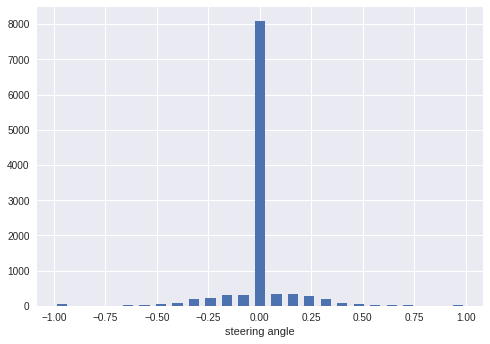

In [111]:
# center the histogram on 0
centered = (bins[:-1] + bins[1:])*0.5
plt.bar(centered, hist, width=0.05)
plt.xlabel('steering angle')

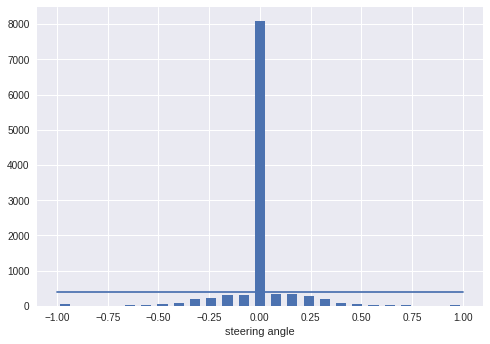

In [112]:
# Given the distribution the model could be biased to go to the center -> reject data above some thershold, to have more uniform data

samples_per_bin = 400
plt.bar(centered, hist, width=0.05)
plt.xlabel('steering angle')
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

### Balancing data

total data:  10698
removed:  7686
remaining:  3012


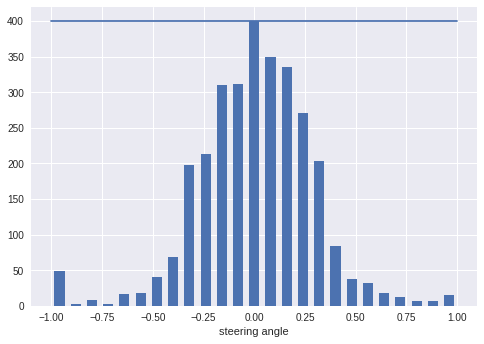

In [113]:
#  specify the samples we want to remove

# shuffle because the data was recorded in order, to not remove a whole part of the track
from sklearn.utils import shuffle

print('total data: ', len(data))
remove_list = []
for j in range(nbins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], nbins)
plt.bar(centered, hist, width=0.05)
plt.xlabel('steering angle')
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

### Training and validation split

In [114]:
from sklearn.model_selection import train_test_split

print(data.iloc[1])
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
#     # left image append
#     image_path.append(os.path.join(datadir,left.strip()))
#     steering.append(float(indexed_data[3])+0.15)
#     # right image append
#     image_path.append(os.path.join(datadir,right.strip()))
#     steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))

center      center_2019_02_07_17_35_34_918.jpg
left        left_2019_02_07_17_35_34_918.jpg  
right       right_2019_02_07_17_35_34_918.jpg 
steering   -0.0956421                         
throttle    1                                 
reverse     0                                 
speed       3.38217                           
Name: 17, dtype: object
Training Samples: 2409
Validation Samples: 603


Text(0.5, 1.0, 'Validation set')

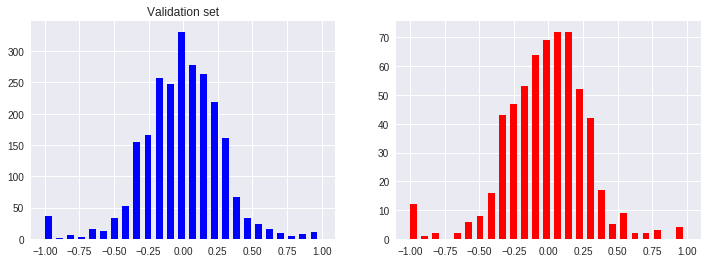

In [115]:
fig, axis = plt.subplots(1,2, figsize=(12,4))
axis[0].hist(y_train, bins=nbins, width=0.05, color='blue')
axis[0].set_title('Training set')
axis[1].hist(y_valid, bins=nbins, width=0.05, color='red')
axis[0].set_title('Validation set')


In [0]:
# Data aug
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) #zoom up to 30%
  image = zoom.augment_image(image)
  return image

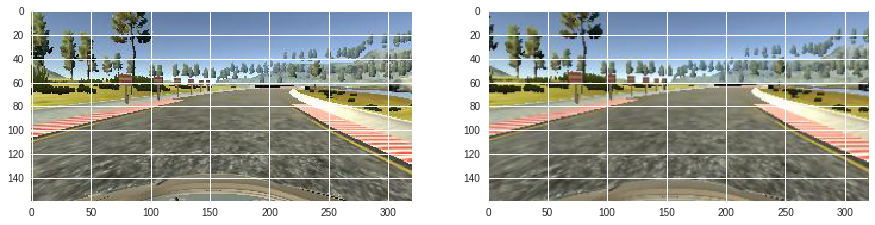

In [117]:
# Data aug
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(zoomed_image)

In [0]:
# Data aug
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image
  

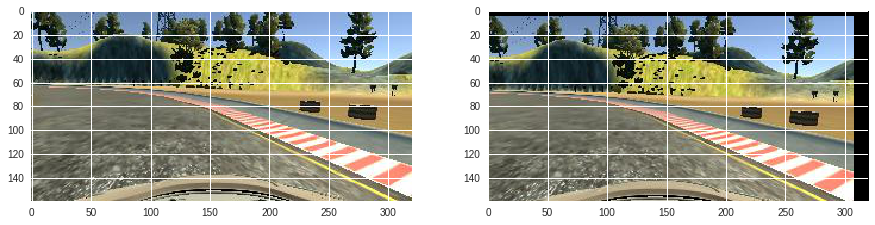

In [119]:
# Data aug
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpimg.imread(image)
pan_image = pan(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(pan_image)

In [0]:
# Data aug
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

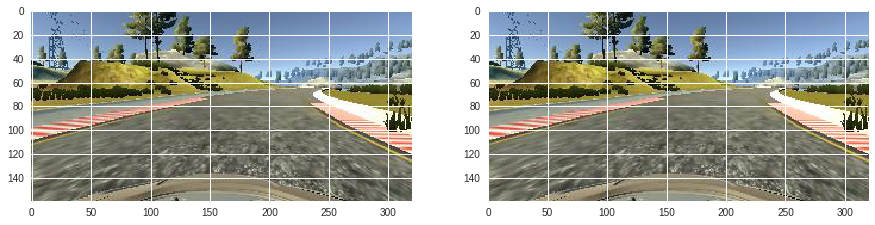

In [121]:
# data aug
image = image_paths[random.randint(0, len(image_paths)-1)]
original_image = mpimg.imread(image)
bight_altered_image = img_random_brightness(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(bight_altered_image)

In [0]:
# Data aug
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, '0.08527289')

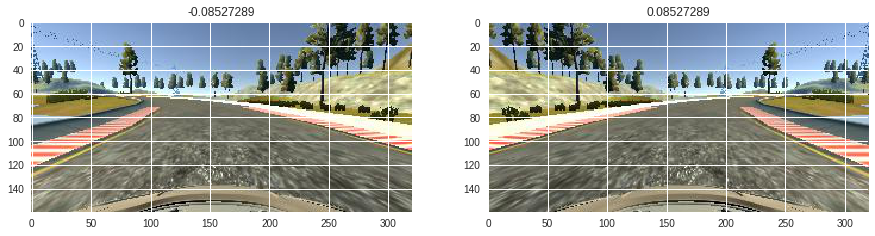

In [123]:
# data aug
ran_index = random.randint(0, len(image_paths)-1)
image = image_paths[ran_index]
steering_angle = steerings[ran_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[0].set_title(str(steering_angle))
axis[1].imshow(flipped_image)
axis[1].set_title(str(flipped_steering_angle))

In [0]:
# data aug
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5: # it is applied to 50% of original images
    image = pan(image)
  if np.random.rand() < 0.5: # it is applied to 50% of original images
    image = zoom(image)
  if np.random.rand() < 0.5: # it is applied to 50% of original images
    image = img_random_brightness(image)
  if np.random.rand() < 0.5: # it is applied to 50% of original images
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

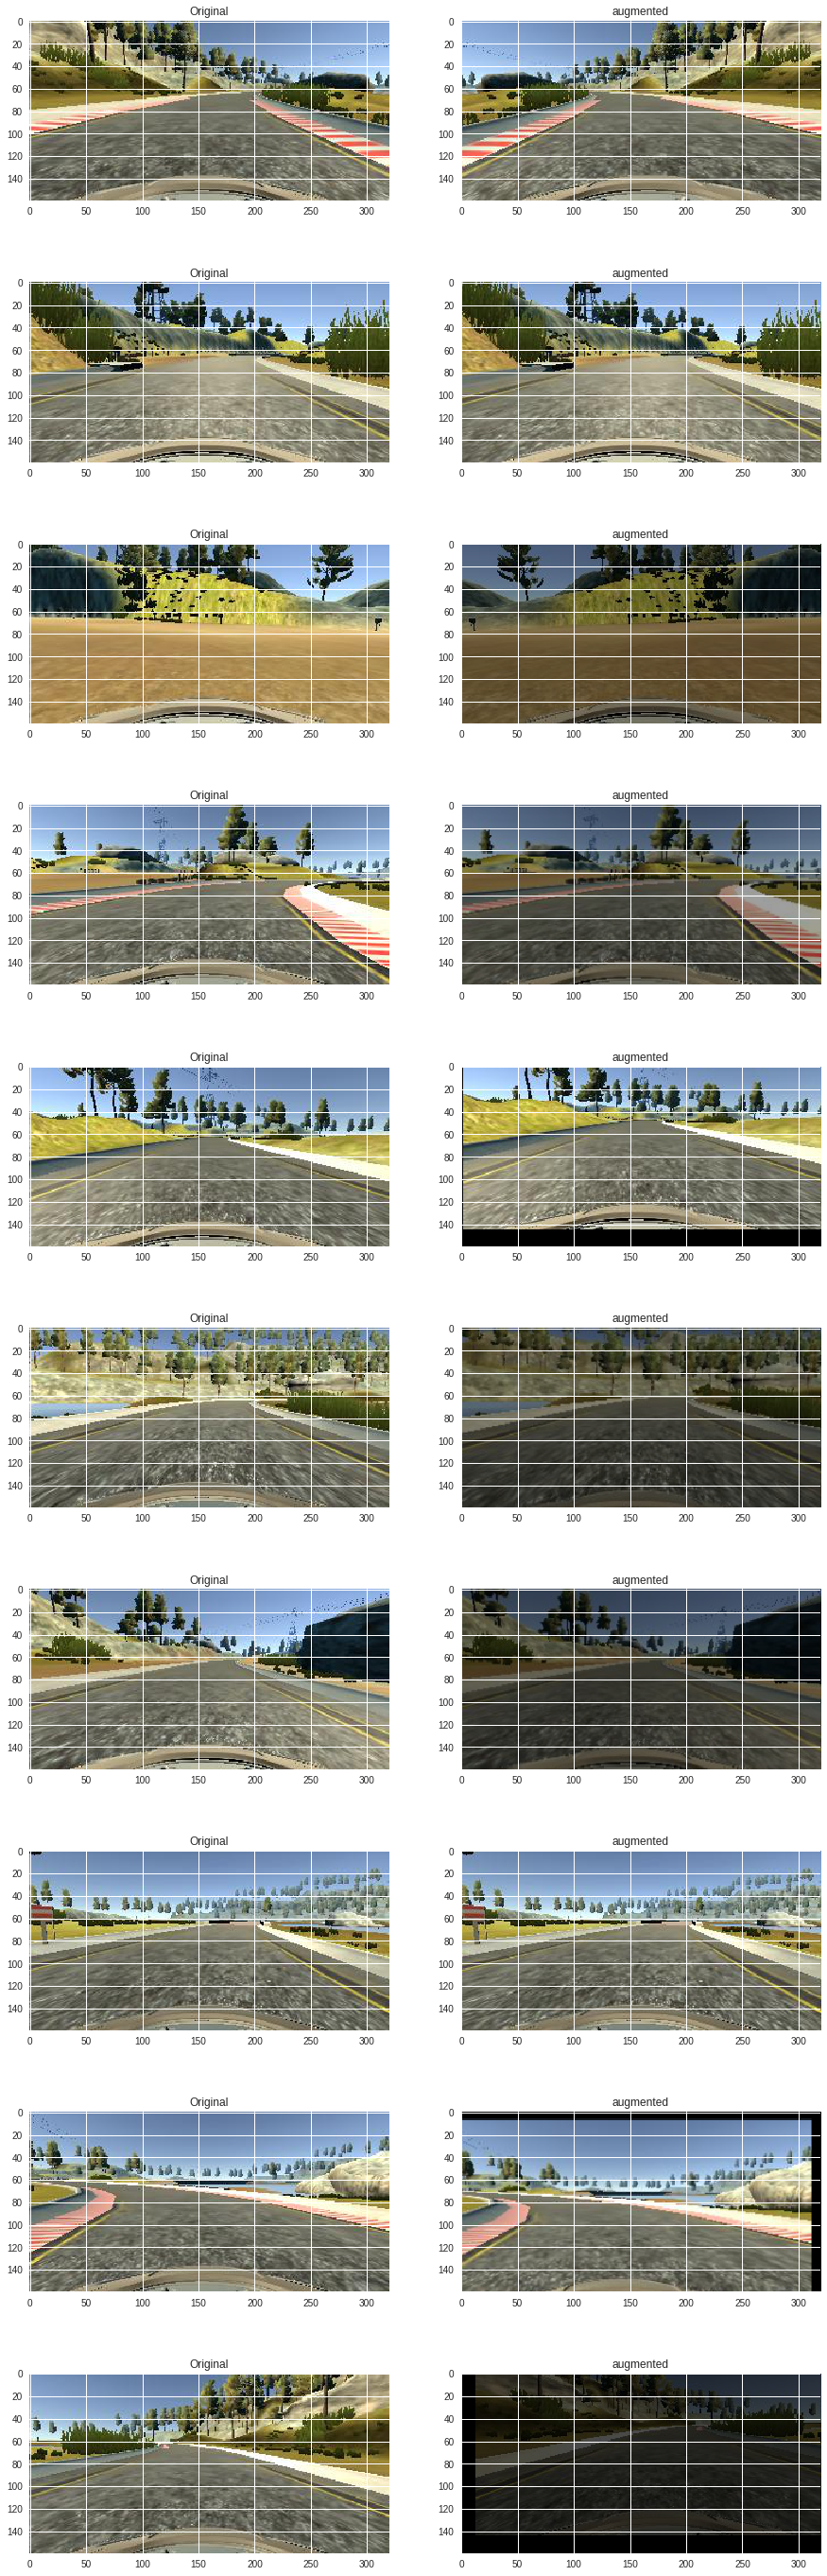

In [125]:
# data aug
ncol = 2
nrow = 10
fig, axis = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
  randnum =random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering_angle = random_augment(random_image, random_steering)
  
  axis[i][0].imshow(original_image)
  axis[i][0].set_title('Original')
  axis[i][1].imshow(augmented_image)
  axis[i][1].set_title('augmented')

In [0]:
import matplotlib.image as mpimg
def img_preprocess(img):
    img = mpimg.imread(img)
    return img

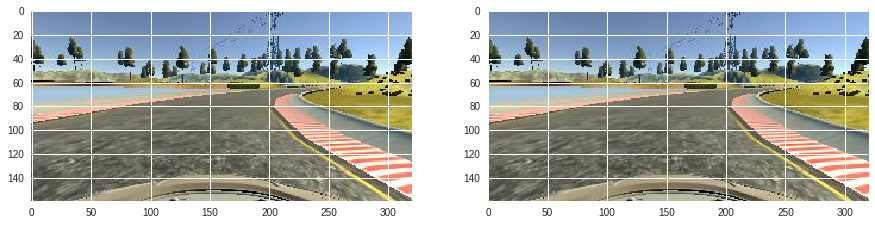

In [127]:
image = image_paths[random.randint(0, len(image_paths))]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(preprocessed_image)

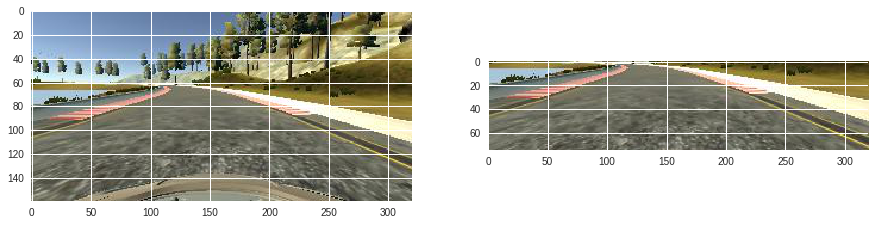

In [128]:
# crop the image to get only region of interest
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :]
    return img

image = image_paths[random.randint(0, len(image_paths))]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(preprocessed_image)

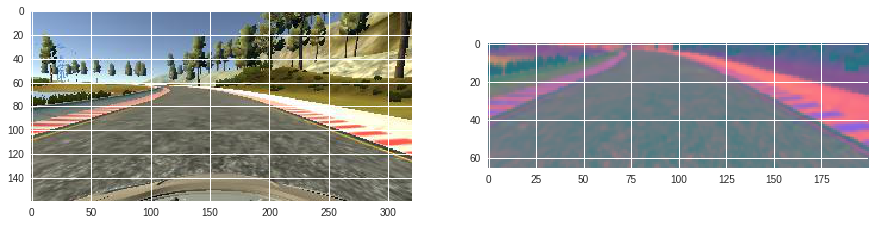

In [129]:
# Following NVIDIA Model(CNN), convert the image to YUV

import cv2

def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255 #normalization
    return img

image = image_paths[random.randint(0, len(image_paths))-1]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
axis[0].imshow(original_image)
axis[1].imshow(preprocessed_image)

(2409, 66, 200, 3)


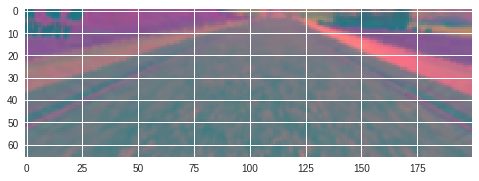

In [130]:
# Preprocess the whole trainig set
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

plt.imshow(X_train[random.randint(0, len(X_train))-1])
print(X_train.shape)

### Nvidia model

In [0]:
# # Popular model for behavioral cloning

# def nvidia_model():
#   model = Sequential()
# #   subsample: stride size
#   model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu'))
#   model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
#   model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
#   model.add(Convolution2D(64, 3, 3, activation='relu'))
#   model.add(Convolution2D(64, 3, 3, activation='relu'))
#   model.add(Dropout(0.5))
  
#   model.add(Flatten())
#   model.add(Dense(100, activation='relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(50, activation='relu'))
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(1))
#   optimizer = Adam(lr=1e-3)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

In [0]:
# model = nvidia_model()
# print(model.summary())

In [0]:
# # since we have much less data, we will require more epochs for our training to be effective
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

In [0]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.title('Loss')
# plt.xlabel('epoch')

It's seen than the difference is big and never converging, therefore it is not a good symptom.
What can happen with the ReLU activation function, is the phenomenon called dead ReLU.
https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks

To solve that we cann apply instead the ELU function, that in the negative function return a  negative value.

In [0]:
# Popular model for behavioral cloning

def nvidia_model():
  model = Sequential()
#   subsample: stride size
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5)) # to fight the overfitting saw in the graphs
 
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5)) # to fight the overfitting saw in the graphs

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5)) # to fight the overfitting saw in the graphs

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [149]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_27 (Dropout)         (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 18, 64)         0         
__________

In [150]:
# since we have much less data, we will require more epochs for our training to be effective
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 2409 samples, validate on 603 samples
Epoch 1/30
2409/2409 [==============================] - 3s 1ms/step - loss: 0.9300 - val_loss: 0.0881
Epoch 2/30
2409/2409 [==============================] - 2s 690us/step - loss: 0.1781 - val_loss: 0.0850
Epoch 3/30
2409/2409 [==============================] - 2s 680us/step - loss: 0.1179 - val_loss: 0.0831
Epoch 4/30
2409/2409 [==============================] - 2s 674us/step - loss: 0.1025 - val_loss: 0.0819
Epoch 5/30
2409/2409 [==============================] - 2s 670us/step - loss: 0.1027 - val_loss: 0.0799
Epoch 6/30
2409/2409 [==============================] - 2s 666us/step - loss: 0.0940 - val_loss: 0.0783
Epoch 7/30
2409/2409 [==============================] - 2s 662us/step - loss: 0.0937 - val_loss: 0.0783
Epoch 8/30
2409/2409 [==============================] - 2s 662us/step - loss: 0.0940 - val_loss: 0.0770
Epoch 9/30
2409/2409 [==============================] - 2s 666us/step - loss: 0.0907 - val_loss: 0.0755
Epoch 10/30
2409/24

Text(0.5, 0, 'epoch')

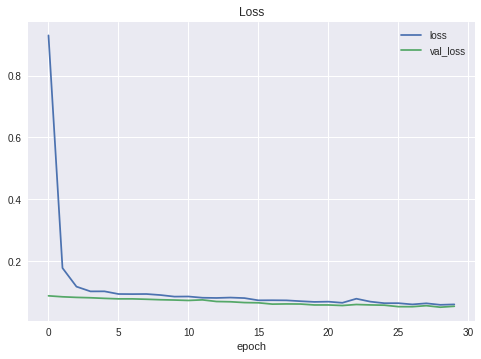

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

### Saving model

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')